In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import datetime as dt
from jqdata import *
import seaborn as sns
import matplotlib as mpl
'''
           growth                 inflation

rising     股票\商品             国债\商品\黄金   
falling   金融债\国债\黄金        企业债\黄金

[ETF]
股票   159912.XSHE 深300ETF  510310.XSHG HS300ETF 159919.XSHE 300ETF
商品   510170.XSHG 商品ETF(2011/1/25)  
国债   159926.XSHE 国债ETF(2013/8/5)  511010.XSHG 国债ETF(2013/3/25) 
金融债
企业债 511210.XSHG 企业债ETF(2013/3/25)  160720.XSHE 中期企业债LOF(2013/04/01)
黄金   159934.XSHE 黄金ETF(2013/12/16)  518880.XSHG黄金ETF(2013/7/29)

[指数]
股票  000300.XSHG 沪深300
商品  399366.XSHE 国正大宗
国债  000012.XSHG 国债指数
金融债
企业债000013.XSHG 上证企业债指数 20030609
黄金  AU8888.XSGE 黄金指数合约
'''
# 备选股票池,这里用的是ETF
security_dict={
    'growth_rising':['510310.XSHG', '510170.XSHG'],
    'growth_falling':['159926.XSHE'],
    'inflation_rising':['510170.XSHG','518880.XSHG'],
    'inflation_falling':['160720.XSHE','518880.XSHG']
}
start_date = '2014-01-01'
end_date = '2020-06-20'
periods = get_trade_days(start_date, end_date)
# 获取股票列表
growth_rising_list = security_dict['growth_rising']
growth_falling_list = security_dict['growth_falling']
inflation_rising_list = security_dict['inflation_rising']
inflation_falling_list = security_dict['inflation_falling']
stock_list = growth_rising_list + growth_falling_list + inflation_rising_list + inflation_falling_list

In [2]:
# # 数据准备
# # 获取不同经济环境的资产数据
# def get_raw_data(stock_list, frequency='daily', fields=['close'], time_periods, ascending=False):
#     raw_data = pd.DataFrame(index=time_periods)
#     for date in time_periods:
#         price = get_price(stock_list,count=1, end_date=date, frequency=frequency, fields=fields)
# #     return raw_data_df
raw_data = get_price(stock_list,start_date, end_date,frequency='daily',fields=['close'])['close']
# 获取收益率
# price_percentage_change = price.pct_change(periods=1)

#缺失值用前一个填充
raw_data = raw_data.fillna(method='ffill')
#获取收益率:(后一个-前一个)/前一个
price_percentage_change = raw_data.pct_change(periods=1)
price_percentage_change = price_percentage_change.dropna()
# price_percentage_change

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:113: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  fill_paused=fill_paused)


In [51]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576 entries, 2014-01-02 to 2020-06-19
Data columns (total 7 columns):
510310.XSHG    1576 non-null float64
510170.XSHG    1576 non-null float64
159926.XSHE    1576 non-null float64
510170.XSHG    1576 non-null float64
518880.XSHG    1576 non-null float64
160720.XSHE    1576 non-null float64
518880.XSHG    1576 non-null float64
dtypes: float64(7)
memory usage: 138.5 KB


In [53]:
set(raw_data.columns)

{'159926.XSHE', '160720.XSHE', '510170.XSHG', '510310.XSHG', '518880.XSHG'}

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


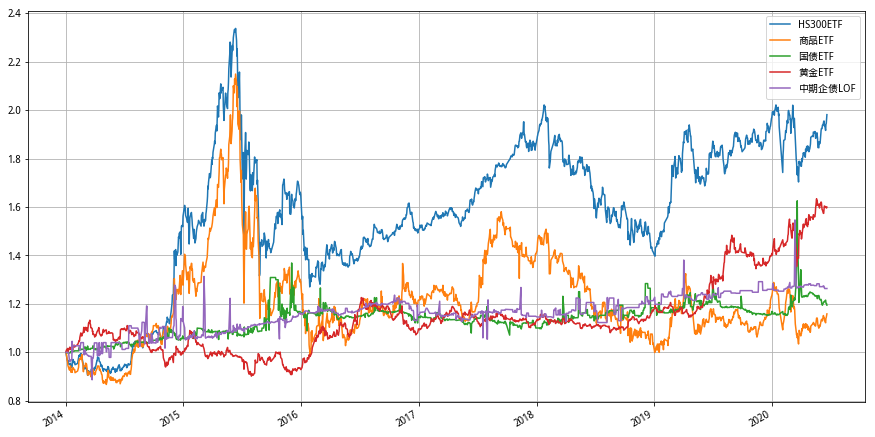

In [3]:
plot_data = raw_data.T.drop_duplicates().T
plot_data = plot_data.rename(columns={'510310.XSHG':'HS300ETF',
                                      '510170.XSHG':'商品ETF',
                                      '159926.XSHE':'国债ETF',
                                      '518880.XSHG':'黄金ETF',
                                      '160720.XSHE':'中期企债LOF'})
(plot_data/plot_data.iloc[0]).plot(figsize=(15,8),grid='on')

In [4]:
global risk_index
# g_r_len = len(growth_rising_list)
# g_f_len = len(growth_falling_list)
# i_r_len = len(inflation_rising_list)
# i_f_len = len(inflation_falling_list)
lens = [len(growth_rising_list),
        len(growth_falling_list),
        len(inflation_rising_list),
        len(inflation_falling_list)]
risk_index = [lens[0], sum(lens[:2]), sum(lens[:3]), sum(lens)]

In [5]:
l = [1,2,3,4,5,6,7,8]
l[risk_index[2]:risk_index[-1]]

[6, 7]

In [6]:
#风险平价获取各资产权重

def get_assets_weight(pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
    if cov_adjusted == False:
        #协方差矩阵
        cov_mat = pct.cov()
    else:
        #调整后的半衰协方差矩阵
        cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
            pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
    if not isinstance(cov_mat, pd.DataFrame):
        raise ValueError('cov_mat should be pandas DataFrame！')
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵

    a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
    a = matrix(a)
    b = matrix(b)
    # 定义目标函数
    # 传统风险平价计算
    # x为权重,Omega是收益率协方差矩阵
    def fun1(x):
        tmp = (omega * np.matrix(x).T).A1  #A1表示变为1行的Array数据结构
        #  这里算的是TRC(i),A1[0]表示变为1行的Array数据结构,取第一个数
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0] 
        # 不同risk之差最小化
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 主成分分析风险平价计算
    def fun2(x):
        tmp = (b**(-1) * omega * np.matrix(x).T).A1
        risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 不同环境资产组合贡献度为25%，计算各个环境内组合的权重
    def fun3(x):
        tmp = (omega * np.matrix(x).T).A1  #A1表示变为1行的Array数据结构
        #  这里算的是TRC(i),A1[0]表示变为1行的Array数据结构,取第一个数
        MRC_arr = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        risk = [sum(MRC_arr[:risk_index[0]]),
                sum(MRC_arr[risk_index[0]:risk_index[1]]),
                sum(MRC_arr[risk_index[1]:risk_index[2]]),
                sum(MRC_arr[risk_index[2]:])]
        # 不同risk之差最小化
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
        pass
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
    if method == 'risk parity':
        res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'pc risk parity':
        res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'all_weather':
        res = minimize(fun3, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    else:
        raise ValueError('method error！！！')
        
    # 权重调整
    if res['success'] == False:
        # print res['message']
        pass
    wts = pd.Series(index=cov_mat.index, data=res['x'])
    
    if wts_adjusted == True:
        wts[wts < 0.0001]=0.0
        wts = wts / wts.sum()
    elif wts_adjusted == False:
        wts = wts / wts.sum()
    else:
        raise ValueError('wts_adjusted should be True/False！')
        
    risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
    risk[risk<0.0] = 0.0
    return wts,risk

#############################################
# 获取调仓日
#############################################

#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('510310.XSHG',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid,how='last')
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date=start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list=date_only_series.values.tolist()
    date_list.insert(0,start_date)
    return date_list

def get_near_tradingday(date):
    return (get_price('510310.XSHG',end_date=date,count=1).index[0])

#月调仓,这里时间需要设置在前面时间中间进行测试
date_list = (get_period_date('M','2014-12-31', '2020-05-30'))
# type(date_list[0])
tradingday_list_tot = price_percentage_change.index.tolist()
tradingday_list = [date for date in price_percentage_change.index.tolist() if ((date)>=get_near_tradingday(date_list[0]) \
                                                                 and (date)<=get_near_tradingday(date_list[-1]))]
np.array(date_list)
# tradingday_list


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:96: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


array([2014-12-30, 2014-12-31, 2015-01-31, 2015-02-28, 2015-03-31,
       2015-04-30, 2015-05-31, 2015-06-30, 2015-07-31, 2015-08-31,
       2015-09-30, 2015-10-31, 2015-11-30, 2015-12-31, 2016-01-31,
       2016-02-29, 2016-03-31, 2016-04-30, 2016-05-31, 2016-06-30,
       2016-07-31, 2016-08-31, 2016-09-30, 2016-10-31, 2016-11-30,
       2016-12-31, 2017-01-31, 2017-02-28, 2017-03-31, 2017-04-30,
       2017-05-31, 2017-06-30, 2017-07-31, 2017-08-31, 2017-09-30,
       2017-10-31, 2017-11-30, 2017-12-31, 2018-01-31, 2018-02-28,
       2018-03-31, 2018-04-30, 2018-05-31, 2018-06-30, 2018-07-31,
       2018-08-31, 2018-09-30, 2018-10-31, 2018-11-30, 2018-12-31,
       2019-01-31, 2019-02-28, 2019-03-31, 2019-04-30, 2019-05-31,
       2019-06-30, 2019-07-31, 2019-08-31, 2019-09-30, 2019-10-31,
       2019-11-30, 2019-12-31, 2020-01-31, 2020-02-29, 2020-03-31,
       2020-04-30, 2020-05-31], dtype='<U10')

In [31]:
tradingday_list[:5]

[Timestamp('2014-12-30 00:00:00'),
 Timestamp('2014-12-31 00:00:00'),
 Timestamp('2015-01-05 00:00:00'),
 Timestamp('2015-01-06 00:00:00'),
 Timestamp('2015-01-07 00:00:00')]

In [35]:
# 将每个调仓点的资产权重与风险权重保存下来

#全天候模型的各资产权重
weight_aw = pd.DataFrame()
weight_aw2 = pd.DataFrame()
weight_aw3 = pd.DataFrame()
# 全天候模型各资产风险贡献权重
risk_aw = pd.DataFrame()
risk_aw2 = pd.DataFrame()
risk_aw3 = pd.DataFrame()
# 计算资产权重与风险贡献权重
t1=dt.datetime.now()
for date in date_list[:]:
    t2=dt.datetime.now()
    print ('计算到%s,已耗时%s秒'%(date,(t2-t1).seconds))
    # 资产收益率协方差根据历史90个交易日进行估计
    date_pre_y = tradingday_list_tot[tradingday_list_tot.index(get_near_tradingday(date))-90] # 如果是年的话,这里需要改成240
    
    #全天候
    weight_and_risk_aw = get_assets_weight(price_percentage_change.loc[date_pre_y:get_near_tradingday(date)],method='all_weather', cov_adjusted=0, wts_adjusted=1)#.reindex(pct_daily.columns).fillna(0)
    weight_aw.loc[:,get_near_tradingday(date)] = weight_and_risk_aw[0]
    risk_aw.loc[:,get_near_tradingday(date)] = weight_and_risk_aw[1]
    
    #普通风险平价
    weight_and_risk_aw2 = get_assets_weight(price_percentage_change.loc[date_pre_y:get_near_tradingday(date)],method='risk parity', cov_adjusted=0, wts_adjusted=1)#.reindex(pct_daily.columns).fillna(0)
    weight_aw2.loc[:,get_near_tradingday(date)] = weight_and_risk_aw2[0]
    risk_aw2.loc[:,get_near_tradingday(date)] = weight_and_risk_aw2[1]
    
    #主成分
    weight_and_risk_aw3 = get_assets_weight(price_percentage_change.loc[date_pre_y:get_near_tradingday(date)],method='pc risk parity', cov_adjusted=0, wts_adjusted=1)#.reindex(pct_daily.columns).fillna(0)
    weight_aw3.loc[:,get_near_tradingday(date)] = weight_and_risk_aw3[0]
    risk_aw3.loc[:,get_near_tradingday(date)] = weight_and_risk_aw3[1]
    
    
    
    
weight_aw = weight_aw.T
risk_aw = risk_aw.T

    
weight_aw2 = weight_aw2.T
risk_aw2 = risk_aw2.T

    
weight_aw3 = weight_aw3.T
risk_aw3 = risk_aw3.T

计算到2014-12-30,已耗时0秒
计算到2014-12-31,已耗时0秒
计算到2015-01-31,已耗时0秒
计算到2015-02-28,已耗时0秒
计算到2015-03-31,已耗时0秒
计算到2015-04-30,已耗时0秒
计算到2015-05-31,已耗时1秒
计算到2015-06-30,已耗时1秒
计算到2015-07-31,已耗时1秒
计算到2015-08-31,已耗时1秒
计算到2015-09-30,已耗时1秒
计算到2015-10-31,已耗时1秒
计算到2015-11-30,已耗时1秒
计算到2015-12-31,已耗时2秒
计算到2016-01-31,已耗时2秒
计算到2016-02-29,已耗时2秒
计算到2016-03-31,已耗时2秒
计算到2016-04-30,已耗时2秒
计算到2016-05-31,已耗时2秒
计算到2016-06-30,已耗时3秒
计算到2016-07-31,已耗时3秒
计算到2016-08-31,已耗时3秒
计算到2016-09-30,已耗时3秒
计算到2016-10-31,已耗时3秒
计算到2016-11-30,已耗时4秒
计算到2016-12-31,已耗时4秒
计算到2017-01-31,已耗时4秒
计算到2017-02-28,已耗时4秒
计算到2017-03-31,已耗时4秒
计算到2017-04-30,已耗时4秒
计算到2017-05-31,已耗时5秒
计算到2017-06-30,已耗时5秒
计算到2017-07-31,已耗时5秒
计算到2017-08-31,已耗时5秒
计算到2017-09-30,已耗时5秒
计算到2017-10-31,已耗时6秒
计算到2017-11-30,已耗时6秒
计算到2017-12-31,已耗时6秒
计算到2018-01-31,已耗时6秒
计算到2018-02-28,已耗时6秒
计算到2018-03-31,已耗时6秒
计算到2018-04-30,已耗时7秒
计算到2018-05-31,已耗时7秒
计算到2018-06-30,已耗时7秒
计算到2018-07-31,已耗时7秒
计算到2018-08-31,已耗时7秒
计算到2018-09-30,已耗时7秒
计算到2018-10-31,已耗时8秒
计算到2018-11-30,已耗时8秒
计算到2018-12-31,已耗时8秒


In [46]:
weight_aw.describe()

,510310.XSHG,510170.XSHG,159926.XSHE,510170.XSHG,518880.XSHG,160720.XSHE,518880.XSHG
count,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000
mean,0.120870,0.063113,0.255158,0.064239,0.165100,0.152745,0.178775
std,0.032361,0.026095,0.081225,0.033524,0.030419,0.064591,0.037298
min,0.053477,0.011978,0.129576,0.000000,0.088509,0.000000,0.061526
25%,0.098449,0.044279,0.204786,0.037735,0.148663,0.114030,0.156868
50%,0.118110,0.063885,0.240439,0.064616,0.160622,0.164775,0.174951
75%,0.148300,0.082845,0.310513,0.091827,0.190763,0.198268,0.204342
max,0.185467,0.113433,0.452080,0.124912,0.233478,0.270107,0.271273


In [47]:
weight_aw2.describe()

,510310.XSHG,510170.XSHG,159926.XSHE,510170.XSHG,518880.XSHG,160720.XSHE,518880.XSHG
count,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000
mean,0.124489,0.063206,0.187435,0.063206,0.189801,0.182062,0.189801
std,0.044735,0.016419,0.076507,0.016419,0.056794,0.097706,0.056794
min,0.047345,0.035262,0.079370,0.035262,0.079407,0.068652,0.079407
25%,0.092149,0.050822,0.125446,0.050822,0.137521,0.104390,0.137521
50%,0.120717,0.059321,0.159794,0.059321,0.198431,0.156645,0.198431
75%,0.157407,0.070853,0.250762,0.070853,0.235683,0.243663,0.235683
max,0.218149,0.108750,0.351325,0.108750,0.289923,0.433619,0.289923


In [48]:
weight_aw3.describe()

,510310.XSHG,510170.XSHG,159926.XSHE,510170.XSHG,518880.XSHG,160720.XSHE,518880.XSHG
count,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000
mean,0.159005,0.026690,0.232148,0.026690,0.182836,0.189795,0.182836
std,0.119950,0.025925,0.133419,0.025925,0.079795,0.128161,0.079795
min,0.000000,0.000000,0.024976,0.000000,0.000639,0.000000,0.000639
25%,0.063114,0.002193,0.143548,0.002193,0.120363,0.093542,0.120363
50%,0.134065,0.023495,0.188966,0.023495,0.170014,0.151750,0.170014
75%,0.228158,0.042344,0.328721,0.042344,0.247007,0.285616,0.247007
max,0.433662,0.124295,0.578609,0.124295,0.385112,0.519708,0.385112


In [8]:
weight_aw.index

DatetimeIndex(['2014-12-30', '2014-12-31', '2015-01-30', '2015-02-27',
               '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30',
               '2015-11-30', '2015-12-31', '2016-01-29', '2016-02-29',
               '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30',
               '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-30', '2017-01-26', '2017-02-28',
               '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31',
               '2017-11-30', '2017-12-29', '2018-01-31', '2018-02-28',
               '2018-03-30', '2018-04-27', '2018-05-31', '2018-06-29',
               '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31',
               '2018-11-30', '2018-12-28', '2019-01-31', '2019-02-28',
               '2019-03-29', '2019-04-30', '2019-05-31', '2019-06-28',
      

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#de

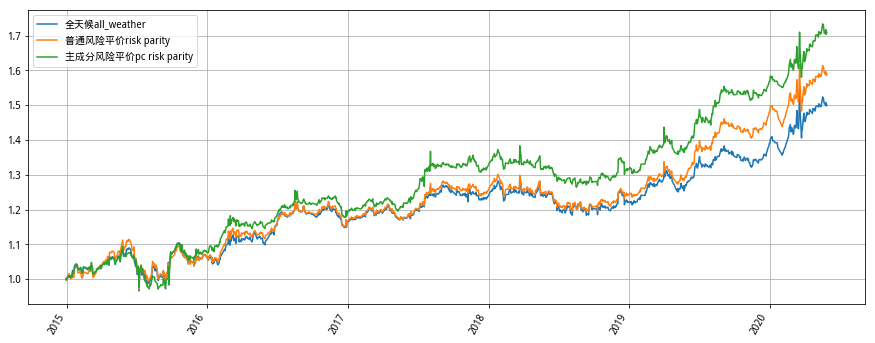

In [36]:
# 策略净值曲线，与单个资产净值曲线对比
########################################
 #回测期间的资产收益率
# reindex相当于一个切片,把参数列表中的index选中(这里就是调仓时的日期对应的pct)
pct_new = price_percentage_change.loc[tradingday_list]

#全天候模型的各资产权重
weight_aw = weight_aw.loc[tradingday_list].fillna(method='ffill')
weight_aw2 = weight_aw2.loc[tradingday_list].fillna(method='ffill')
weight_aw3 = weight_aw3.loc[tradingday_list].fillna(method='ffill')

# # 全天候模型各资产风险贡献权重
# risk_aw = risk_aw.T.reindex(tradingday_list).fillna(method='ffill')

# 净值
net_value=pd.DataFrame()
# cumprod()为累加,默认为0,表示按0方向,第一行为自己,第二行结果为第一行加第二行
# 第三行为前三行相加,以此类推
net_value['全天候all_weather'] = (weight_aw*(pct_new+1)).sum(axis=1).cumprod()
net_value['普通风险平价risk parity'] = (weight_aw2*(pct_new+1)).sum(axis=1).cumprod()
net_value['主成分风险平价pc risk parity'] = (weight_aw3*(pct_new+1)).sum(axis=1).cumprod()

#画净值曲线
net_value.plot(figsize=(15,6),grid='on',rot=60)

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


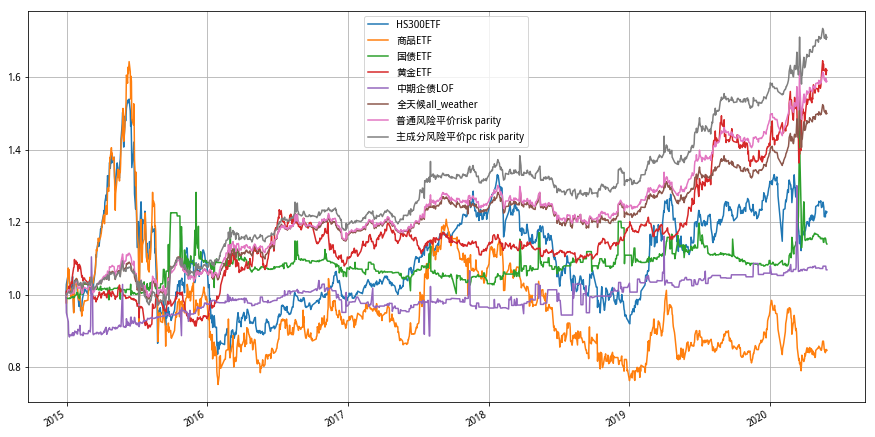

In [38]:
# 与各成分资产比较
plot_data = plot_data.loc[net_value.index]
original_stuff = plot_data/plot_data.iloc[0]
plot_total = pd.concat([original_stuff,net_value],axis=1).dropna()
plot_total.plot(figsize=(15,8),grid='on')

In [39]:
plot_total

,HS300ETF,商品ETF,国债ETF,黄金ETF,中期企债LOF,全天候all_weather,普通风险平价risk parity,主成分风险平价pc risk parity
2014-12-30,1.000000,1.000000,1.000000,1.000000,1.000000,1.000759,1.000723,1.001385
2014-12-31,1.028592,0.976140,0.990313,1.010050,0.950549,1.000429,0.995890,0.997728
2015-01-05,1.057898,1.073701,0.989528,1.010888,0.925824,1.011254,1.013348,1.007328
2015-01-06,1.051465,1.046129,0.989361,1.019682,0.891026,1.011444,1.008816,1.006553
2015-01-07,1.050751,1.068929,0.989410,1.023869,0.886447,1.014902,1.013597,1.010154
2015-01-08,1.030736,1.040297,0.991275,1.018007,0.883700,1.009379,1.005802,1.005343
2015-01-09,1.027877,1.030223,0.989606,1.021357,0.889194,1.008949,1.004946,1.005127
2015-01-12,1.020014,0.993107,0.991196,1.029313,0.887363,1.008889,1.001292,1.005086
2015-01-13,1.014296,0.996819,0.992266,1.034757,0.891026,1.011344,1.003958,1.008040
2015-01-14,1.011437,0.995228,0.993463,1.032663,0.889194,1.010649,1.003005,1.007437


In [54]:
# 策略评价
class backtest_result():
    def __init__(self,data):
        self.data = data
        self.total_returns = data.iloc[-1]-1
        self.annualized_returns = data.iloc[-1]**(250./len(data))-1
        self.annualized_volatility = data.pct_change().std()*(250.**0.5)
    def Max_Drawback(self):
        net_value=self.data
        max_value=0
        df_tmp=pd.DataFrame(net_value)
        df_tmp.columns=['value']
        for j in range(0,len(net_value),1):
            max_value=max(max_value,df_tmp.ix[j,'value'])
            df_tmp.ix[j,'drawback']=1-df_tmp.ix[j,'value']/max_value
            drawback=df_tmp['drawback'].max()
        return drawback
    def Sharpe(self):
        net_value=self.data
        bench_pct=0.03
        df_tmp=pd.DataFrame(net_value)
        df_tmp.columns=['value']
        df_tmp['pct']=df_tmp['value'].pct_change()
        annual_pct = df_tmp.ix[-1,'value']**(250./len(df_tmp))-1
        sharpe = (annual_pct-bench_pct)/(df_tmp['pct'].std()*250**0.5)
        return sharpe
    def Calmar(self):
        clamar = self.annualized_returns/self.Max_Drawback()
        return clamar

aresults=pd.DataFrame()
for c in list(plot_total.columns):
    nv = plot_total[c]
    aresults.loc['累计收益率',c]=backtest_result(nv).total_returns*100
    aresults.loc['年化收益率',c]=backtest_result(nv).annualized_returns*100
    aresults.loc['年化波动率',c]=backtest_result(nv).annualized_volatility*100
    aresults.loc['最大回撤',c]=backtest_result(nv).Max_Drawback()*100
    aresults.loc['夏普比率',c]=backtest_result(nv).Sharpe()*100
    aresults.loc['Calmar比率',c]=backtest_result(nv).Calmar()*100
aresults

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,HS300ETF,商品ETF,国债ETF,黄金ETF,中期企债LOF,全天候all_weather,普通风险平价risk parity,主成分风险平价pc risk parity
累计收益率,22.802001,-15.270414,13.972205,61.809045,6.868132,49.931445,58.810865,70.920757
年化收益率,3.973008,-3.094238,2.511763,9.557958,1.267938,7.985033,9.169979,10.702347
年化波动率,25.858084,32.332546,24.087655,12.906568,22.548115,10.363008,10.001319,10.592477
最大回撤,45.657222,54.149177,25.814958,17.290076,19.734660,11.359325,12.911175,11.128379
夏普比率,3.762877,-18.848619,-2.026920,50.811014,-7.681625,48.104116,61.691652,72.715263
Calmar比率,8.701817,-5.714285,9.729873,55.280022,6.424931,70.294964,71.023579,96.171663
